In [ ]:
"""

Date: June 24, 2020

Author: Karine Choquet

This script will make the final Figure 2 for the nano-COP Nature Protocols manuscript, which compares nano-COP to 
direct RNA-seq of chromatin RNA and direct cDNA sequencing of 4sU-chromatin RNA.



"""

In [1]:
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

import math

import pybedtools
from pybedtools import BedTool

from collections import Counter

## FIGURE 2A

In [2]:
# functions for making splicing order dictionary

# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def hg38_introns(intronFile):
    # make a set for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = name_split[1].split('_')[1]             # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    #introns_df = pd.DataFrame(introns)
    #introns_df.columns = ["chrom","start","end","gene","feature","strand"]
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def dmel_introns(intronFile):
    # make a set for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = 'chr'+str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = name_split[1].split('_')[1]             # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    #introns_df = pd.DataFrame(introns)
    #introns_df.columns = ["chrom","start","end","gene","feature","strand"]
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to create a dataframe with reads that span 3'SS positions
def get_intron_intersect(introns_df, bam_file):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bam_file.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(introns_df, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df = intersect.to_dataframe(names=['chr_aln', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_intron', 'start_intron', \
                                           'end_intron', 'name_gene', 'intron_count', 'strand_gene', 'count'], \
                               dtype={"chr_aln": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_intron": str, "start_intron": int, \
                                     "end_intron": int, "name_gene": str, \
                                     "intron_count": int,"strand_gene": str, "count": int}) # convert to a dataframe
    return df


# function to create a dataframe with splicing information for
# every read that spans an intron in the dataset
def get_splicing_info(intersect_df, min_overlap):
    
    df = intersect_df

    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all read-intron intersects
    for i in range(0,df.shape[0]):

        # ignore reads that do not overlap intron by minimum threshold
        if (df['count'].iloc[i] < min_overlap):
            continue

        # record the start and ends of reads 
        # will deal with gene strand after cigar counts are made
        aln_start = df['start_aln'].iloc[i] # record the start of the read
        aln_end = df['end_aln'].iloc[i] # record the end of the read
        intron_start = df['start_intron'].iloc[i] # record the end of the intron
        intron_end = df['end_intron'].iloc[i] # record the end of the intron

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df['cigar_aln'].iloc[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df['start_aln'].iloc[i])

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated intron start
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated intron end
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # get length of the aligned portion of this read from cigar string
        aligned_read_length = CigarOp_counts['M']+CigarOp_counts['D']

        # get 5'SS and 3'SS counts as determined by gene strand
        strand = df['strand_gene'].iloc[i]
        if (strand == '+'):
            aln_start = df['start_aln'].iloc[i] # record the start of the read
            aln_end = df['end_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = start_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = end_counts # record the cigar string counts over the 3'SS
            read_overlap = intron_end - (aln_end - aligned_read_length + min_overlap)
            
        if (strand == '-'):
            aln_start = df['end_aln'].iloc[i] # record the start of the read
            aln_end = df['start_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = end_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = start_counts # record the cigar string counts over the 3'SS  
            read_overlap = (aln_end + aligned_read_length - min_overlap) - intron_start
            
        # annotate splicing status based on CIGAR string information around splice sites
        splice='UNDETERMINED'

        if (intron_5SS_counts['N']==0 and intron_3SS_counts['N']==0):
            if (intron_3SS_counts['M']+intron_3SS_counts['D']==min_overlap*2):
                if (intron_3SS_counts['M']>min_overlap):
                    splice = 'NO'

        if (intron_5SS_counts['N']>0 and intron_5SS_counts['N']<min_overlap*2):
            if (intron_3SS_counts['N']>0 and intron_3SS_counts['N']<min_overlap*2):
                splice = 'YES'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))

                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)

                # if read is unspliced, at least 75% of the read has to match (CIGAR=M) the intron sequence
                if(intron_counts['M'] < min_overlap/2 or ratio < 0.75):
                    splice='UNDETERMINED'
            
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        # save read, intron, and splicing information
        spliceCalls.append([df['name_aln'].iloc[i],df['chr_intron'].iloc[i],intron_start,intron_end,df['strand_gene'].iloc[i],df['name_gene'].iloc[i],df['intron_count'].iloc[i],read_overlap,splice])

    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","strand","gene_name","intron_count","read_overlap","splice_status"]

    return spliceCalls_df


# every read that spans an intron in the dataset
def get_read_junctions_dictionary(splice_df):

    read_junctions = {}

    for i in range(0,splice_df.shape[0]):       

        # define the read name
        read_name = splice_df['read_name'].iloc[i]
        gene_name = splice_df['gene_name'].iloc[i]
        chrom = splice_df['chrom'].iloc[i]
        intron_start = splice_df['intron_start'].iloc[i]
        intron_end = splice_df['intron_end'].iloc[i]
        intron_count = splice_df['intron_count'].iloc[i]
        strand = splice_df['strand'].iloc[i]
        read_overlap = splice_df['read_overlap'].iloc[i]
        splice_status = splice_df['splice_status'].iloc[i]

        # check if read name is in the dictionary, if not save it
        if read_name not in read_junctions.keys():

            # make a new dictionary for the gene and add intron info to it
            read_junctions[read_name] = {}
            read_junctions[read_name][gene_name] = [[chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status]]

        # check if read name is in the dictionary, if it is proceed to gene information
        elif read_name in read_junctions.keys():

            # if gene_name is not already in read dictionary, 
            # make a new dictionary for the gene and add intron info to it
            if gene_name not in read_junctions[read_name].keys():
                read_junctions[read_name][gene_name] = [[chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status]]

            # if gene_name is already in read dictionary, add new intron info to it
            elif gene_name in read_junctions[read_name].keys():
                read_junctions[read_name][gene_name].append([chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status])

    return read_junctions



def get_read_splicing_counts(name, read_junctions):
    
    read_property = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) > 1 ):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    if (unspliced_count>1) and (spliced_count==0):
                        read_property.append([read, gene, 'all_unspliced'])

                    if (unspliced_count==0) and (spliced_count>1):
                        read_property.append([read, gene, 'all_spliced'])

                    if (unspliced_count>=1) and (spliced_count>=1):
                        read_property.append([read, gene, 'intermediate'])

    read_splicing_df = pd.DataFrame(read_property)
    read_splicing_df.columns = ['read','gene','splicing_status']        

    count = []
    spliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='all_spliced'])
    unspliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='all_unspliced'])
    intermediate_count = len(read_splicing_df[read_splicing_df['splicing_status']=='intermediate'])
    count.append([name, spliced_count, unspliced_count, intermediate_count])

    count_df = pd.DataFrame(count)
    count_df.columns = ['sample','all_spliced','all_unspliced','intermediate']

    return read_splicing_df, count_df


def get_intron_splicing_counts(name, read_junctions):

    read_property = []
    tot_spliced = 0
    tot_unspliced = 0

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # characterize the number of spliced and unspliced introns in the read
            splice_status = [row[6] for row in read_junctions[read][gene]]
            splice_status_join = '_'.join(splice_status)
            status_count = Counter(splice_status)

            # only process the file if intron pattern hasn't been seen previously
            # for a gene that this read aligns to
            if (splice_status_join not in uniq_splice_pattern):
                uniq_splice_pattern.add(splice_status_join)

                spliced_count = status_count['YES']
                unspliced_count = status_count['NO']

                tot_spliced = tot_spliced + spliced_count
                tot_unspliced = tot_unspliced + unspliced_count

    percent_spliced = float(tot_spliced)/float(tot_spliced+tot_unspliced)*100.0            
    count = []
    count.append([name, tot_spliced, tot_unspliced, percent_spliced])

    count_df = pd.DataFrame(count)
    count_df.columns = ['sample','spliced','unspliced','percent_spliced']

    return count_df


In [102]:
# set all variables for analysis
min_overlap = 25

# Get human data for figure 3B (Splicing pattern proportions)

# install splice sites from K562 intron files
K562_intronFile = open('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed')

# make a dataframe of intron coordinates
K562_introns_bedtool = hg38_introns(K562_intronFile) 

In [106]:
# Load files from nano-COP Mol Cell paper
# These files were produced using the script nanoCOP_intron_pairs_datasets.ipynb (https://github.com/churchmanlab/nano-COP/)
K562_4sUchr_1_splice_dictionary = np.load('/path/to/K562_4sUchr_ONT_1_splicing_dictionary.npy', encoding='latin1', allow_pickle=True).item()
K562_4sUchr_2_splice_dictionary = np.load('/path/to/K562_4sUchr_ONT_2_splicing_dictionary.npy', encoding='latin1', allow_pickle=True).item()
K562_4sUchr_3_splice_dictionary = np.load('/path/to/K562_4sUchr_ONT_3_splicing_dictionary.npy', encoding='latin1', allow_pickle=True).item()
K562_4sUchr_4_splice_dictionary = np.load('/path/to/K562_4sUchr_ONT_4_splicing_dictionary.npy', encoding='latin1', allow_pickle=True).item()
K562_4sUchr_5a_splice_dictionary = np.load('/path/to/K562_4sUchr_ONT_5a_splicing_dictionary.npy', encoding='latin1', allow_pickle=True).item()
K562_4sUchr_5b_splice_dictionary = np.load('/path/to/K562_4sUchr_ONT_5b_splicing_dictionary.npy', encoding='latin1', allow_pickle=True).item()

In [65]:
# Process chromatin RNA sample - replicate 1 with poly(A) tailing

K562_chr_RNA_1_bamFile = pybedtools.BedTool('/path/to/K562_chr_RNA_1_hg38_minimap2_uniq_sort.bam')

# get reads that intersect introns
K562_chr_RNA_1_intersect = get_intron_intersect(K562_introns_bedtool, K562_chr_RNA_1_bamFile)

# get splicing information for every read that spans an intron
K562_chr_RNA_1_splice_info = get_splicing_info(K562_chr_RNA_1_intersect,min_overlap)

# remove unwanted intron information
K562_chr_RNA_1_splice_info = K562_chr_RNA_1_splice_info[K562_chr_RNA_1_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_chr_RNA_1_splice_info_wiOverlap = K562_chr_RNA_1_splice_info[K562_chr_RNA_1_splice_info['read_overlap']>(K562_chr_RNA_1_splice_info['intron_end']-K562_chr_RNA_1_splice_info['intron_start'])].reset_index(drop=True)

# get dictionary with all intron junctions that a read spans
K562_chr_RNA_1_splice_dictionary = get_read_junctions_dictionary(K562_chr_RNA_1_splice_info_wiOverlap)

# save dictionary
np.save('/path/to/K562_chr_RNA_1_splicing_dictionary.npy', K562_chr_RNA_1_splice_dictionary)



In [66]:
# Process chromatin RNA sample - replicate 2 with poly(I) tailing

K562_chr_RNA_2_bamFile = pybedtools.BedTool('/path/to/K562_chr_RNA_2_hg38_minimap2_uniq_sort.bam')

# get reads that intersect introns
K562_chr_RNA_2_intersect = get_intron_intersect(K562_introns_bedtool, K562_chr_RNA_2_bamFile)

# get splicing information for every read that spans an intron
K562_chr_RNA_2_splice_info = get_splicing_info(K562_chr_RNA_2_intersect,min_overlap)

# remove unwanted intron information
K562_chr_RNA_2_splice_info = K562_chr_RNA_2_splice_info[K562_chr_RNA_2_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_chr_RNA_2_splice_info_wiOverlap = K562_chr_RNA_2_splice_info[K562_chr_RNA_2_splice_info['read_overlap']>(K562_chr_RNA_2_splice_info['intron_end']-K562_chr_RNA_2_splice_info['intron_start'])].reset_index(drop=True)

# get dictionary with all intron junctions that a read spans
K562_chr_RNA_2_splice_dictionary = get_read_junctions_dictionary(K562_chr_RNA_2_splice_info_wiOverlap)

# save dictionary
np.save('/path/to/K562_chr_RNA_2_splicing_dictionary.npy', K562_chr_RNA_2_splice_dictionary)


In [104]:
# function to create a dataframe with reads that span 3'SS positions
def get_intron_intersect_cDNA(introns_df, bam_file):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bam_file.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect1 = bedFile.intersect(introns_df, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df1 = intersect1.to_dataframe(names=['chr_aln', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_intron', 'start_intron', \
                                           'end_intron', 'name_gene', 'intron_count', 'strand_gene', 'count'], \
                               dtype={"chr_aln": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_intron": str, "start_intron": int, \
                                     "end_intron": int, "name_gene": str, \
                                     "intron_count": int,"strand_gene": str, "count": int}) # convert to a dataframe
    
    intersect2 = bedFile.intersect(introns_df, wo=True, S=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df2 = intersect2.to_dataframe(names=['chr_aln', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_intron', 'start_intron', \
                                           'end_intron', 'name_gene', 'intron_count', 'strand_gene', 'count'], \
                               dtype={"chr_aln": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_intron": str, "start_intron": int, \
                                     "end_intron": int, "name_gene": str, \
                                     "intron_count": int,"strand_gene": str, "count": int}) # convert to a dataframe
    
    df = pd.concat([df1,df2]).reset_index(drop=True)
    
    return df


# function to create a dataframe with splicing information for
# every read that spans an intron in the dataset
def get_splicing_info_cDNA(intersect_df, min_overlap):
    
    df = intersect_df

    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all read-intron intersects
    for i in range(0,df.shape[0]):

        # ignore reads that do not overlap intron by minimum threshold
        if (df['count'].iloc[i] < min_overlap):
            continue

        # record the start and ends of reads 
        # will deal with gene strand after cigar counts are made
        aln_start = df['start_aln'].iloc[i] # record the start of the read
        aln_end = df['end_aln'].iloc[i] # record the end of the read
        intron_start = df['start_intron'].iloc[i] # record the end of the intron
        intron_end = df['end_intron'].iloc[i] # record the end of the intron

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df['cigar_aln'].iloc[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df['start_aln'].iloc[i])

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated intron start
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated intron end
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # get length of the aligned portion of this read from cigar string
        aligned_read_length = CigarOp_counts['M']+CigarOp_counts['D']

        # get 5'SS and 3'SS counts as determined by gene strand
        strand = df['strand_gene'].iloc[i]
        strand_aln = df['strand_aln'].iloc[i]
        if (strand == '+') and (strand_aln == '+'):
            aln_start = df['start_aln'].iloc[i] # record the start of the read
            aln_end = df['end_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = start_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = end_counts # record the cigar string counts over the 3'SS
            read_overlap = intron_end - (aln_end - aligned_read_length + min_overlap)
            
        if (strand == '-') and (strand_aln == '-'):
            aln_start = df['end_aln'].iloc[i] # record the start of the read
            aln_end = df['start_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = end_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = start_counts # record the cigar string counts over the 3'SS  
            read_overlap = (aln_end + aligned_read_length - min_overlap) - intron_start
            
        if (strand == '+') and (strand_aln == '-'):
            aln_start = df['end_aln'].iloc[i] # record the start of the read
            aln_end = df['start_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = start_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = end_counts # record the cigar string counts over the 3'SS
            read_overlap = intron_end - (aln_end - aligned_read_length + min_overlap)
            
        if (strand == '-') and (strand_aln == '+'):
            aln_start = df['start_aln'].iloc[i] # record the start of the read
            aln_end = df['end_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = end_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = start_counts # record the cigar string counts over the 3'SS  
            read_overlap = (aln_end + aligned_read_length - min_overlap) - intron_start
            
        # annotate splicing status based on CIGAR string information around splice sites
        splice='UNDETERMINED'

        if (intron_5SS_counts['N']==0 and intron_3SS_counts['N']==0):
            if (intron_3SS_counts['M']+intron_3SS_counts['D']==min_overlap*2):
                if (intron_3SS_counts['M']>min_overlap):
                    splice = 'NO'

        if (intron_5SS_counts['N']>0 and intron_5SS_counts['N']<min_overlap*2):
            if (intron_3SS_counts['N']>0 and intron_3SS_counts['N']<min_overlap*2):
                splice = 'YES'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))

                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)

                # if read is unspliced, at least 75% of the read has to match (CIGAR=M) the intron sequence
                if(intron_counts['M'] < min_overlap/2 or ratio < 0.75):
                    splice='UNDETERMINED'
            
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        # save read, intron, and splicing information
        spliceCalls.append([df['name_aln'].iloc[i],df['chr_intron'].iloc[i],intron_start,intron_end,df['strand_gene'].iloc[i],df['name_gene'].iloc[i],df['intron_count'].iloc[i],read_overlap,splice])

    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","strand","gene_name","intron_count","read_overlap","splice_status"]

    return spliceCalls_df

In [68]:
# Process cDNA-seq sample - replicate 1 with poly(A) tailing

K562_4sUchr_cDNA_1_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_cDNA_1_hg38_minimap2_uniq_sort.bam')

# get reads that intersect introns
K562_4sUchr_cDNA_1_intersect = get_intron_intersect_cDNA(K562_introns_bedtool, K562_4sUchr_cDNA_1_bamFile)

# get splicing information for every read that spans an intron
K562_4sUchr_cDNA_1_splice_info = get_splicing_info_cDNA(K562_4sUchr_cDNA_1_intersect,min_overlap)

# remove unwanted intron information
K562_4sUchr_cDNA_1_splice_info = K562_4sUchr_cDNA_1_splice_info[K562_4sUchr_cDNA_1_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_4sUchr_cDNA_1_splice_info_wiOverlap = K562_4sUchr_cDNA_1_splice_info[K562_4sUchr_cDNA_1_splice_info['read_overlap']>(K562_4sUchr_cDNA_1_splice_info['intron_end']-K562_4sUchr_cDNA_1_splice_info['intron_start'])].reset_index(drop=True)

# get dictionary with all intron junctions that a read spans
K562_4sUchr_cDNA_1_splice_dictionary = get_read_junctions_dictionary(K562_4sUchr_cDNA_1_splice_info_wiOverlap)

# save dictionary
np.save('/path/to/K562_4sUchr_cDNA_1_splicing_dictionary.npy', K562_4sUchr_cDNA_1_splice_dictionary)


In [ ]:
# Process cDNA-seq sample - replicate 2 with poly(I) tailing

K562_4sUchr_cDNA_2_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_cDNA_2_hg38_minimap2_uniq_sort.bam')

# get reads that intersect introns
K562_4sUchr_cDNA_2_intersect = get_intron_intersect_cDNA(K562_introns_bedtool, K562_4sUchr_cDNA_2_bamFile)

# get splicing information for every read that spans an intron
K562_4sUchr_cDNA_2_splice_info = get_splicing_info_cDNA(K562_4sUchr_cDNA_2_intersect,min_overlap)

# remove unwanted intron information
K562_4sUchr_cDNA_2_splice_info = K562_4sUchr_cDNA_2_splice_info[K562_4sUchr_cDNA_2_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_4sUchr_cDNA_2_splice_info_wiOverlap = K562_4sUchr_cDNA_2_splice_info[K562_4sUchr_cDNA_2_splice_info['read_overlap']>(K562_4sUchr_cDNA_2_splice_info['intron_end']-K562_4sUchr_cDNA_2_splice_info['intron_start'])].reset_index(drop=True)

# get dictionary with all intron junctions that a read spans
K562_4sUchr_cDNA_2_splice_dictionary = get_read_junctions_dictionary(K562_4sUchr_cDNA_2_splice_info_wiOverlap)

# save dictionary
np.save('/path/to/K562_4sUchr_cDNA_2_splicing_dictionary.npy', K562_4sUchr_cDNA_2_splice_dictionary)


In [70]:
# collect splicing counts from all cells
K562_4sUchr_1_splicing_status, K562_4sUchr_1_splicing_counts = get_read_splicing_counts('K562_4sUchr_1',K562_4sUchr_1_splice_dictionary)
K562_4sUchr_2_splicing_status, K562_4sUchr_2_splicing_counts = get_read_splicing_counts('K562_4sUchr_2',K562_4sUchr_2_splice_dictionary)
K562_4sUchr_3_splicing_status, K562_4sUchr_3_splicing_counts = get_read_splicing_counts('K562_4sUchr_3',K562_4sUchr_3_splice_dictionary)
K562_4sUchr_4_splicing_status, K562_4sUchr_4_splicing_counts = get_read_splicing_counts('K562_4sUchr_4',K562_4sUchr_4_splice_dictionary)
K562_4sUchr_5a_splicing_status, K562_4sUchr_5a_splicing_counts = get_read_splicing_counts('K562_4sUchr_5a',K562_4sUchr_5a_splice_dictionary)
K562_4sUchr_5b_splicing_status, K562_4sUchr_5b_splicing_counts = get_read_splicing_counts('K562_4sUchr_5b',K562_4sUchr_5b_splice_dictionary)
K562_4sUchr_cDNA_1_splicing_status, K562_4sUchr_cDNA_1_splicing_counts = get_read_splicing_counts('K562_4sUchr_cDNA_1',K562_4sUchr_cDNA_1_splice_dictionary)
K562_4sUchr_cDNA_2_splicing_status, K562_4sUchr_cDNA_2_splicing_counts = get_read_splicing_counts('K562_4sUchr_cDNA_2',K562_4sUchr_cDNA_2_splice_dictionary)
K562_chr_RNA_1_splicing_status, K562_chr_RNA_1_splicing_counts = get_read_splicing_counts('K562_chr_RNA_1',K562_chr_RNA_1_splice_dictionary)
K562_chr_RNA_2_splicing_status, K562_chr_RNA_2_splicing_counts = get_read_splicing_counts('K562_chr_RNA_2',K562_chr_RNA_2_splice_dictionary)

all_nanoCOP_splicing_counts = pd.concat([K562_4sUchr_1_splicing_counts,K562_4sUchr_2_splicing_counts,K562_4sUchr_3_splicing_counts,
                                        K562_4sUchr_4_splicing_counts,K562_4sUchr_5a_splicing_counts,K562_4sUchr_5b_splicing_counts]).reset_index(drop=True)

all_chromatin_splicing_counts = pd.concat([K562_chr_RNA_1_splicing_counts,K562_chr_RNA_2_splicing_counts]).reset_index(drop=True)

all_cDNA_splicing_counts = pd.concat([K562_4sUchr_cDNA_1_splicing_counts,K562_4sUchr_cDNA_2_splicing_counts]).reset_index(drop=True)

# label splicing counts
all_nanoCOP_splicing_counts['sample'] = 'direct RNA chr-4sU'
all_chromatin_splicing_counts['sample'] = 'direct RNA chr'
all_cDNA_splicing_counts['sample'] = 'direct cDNA chr-4sU'


# combine splicing counts
all_splicing_counts = []

all_splicing_counts.append([all_nanoCOP_splicing_counts['sample'].iloc[0],all_nanoCOP_splicing_counts['all_unspliced'].sum(),
                           all_nanoCOP_splicing_counts['intermediate'].sum(), all_nanoCOP_splicing_counts['all_spliced'].sum()])
all_splicing_counts.append([all_chromatin_splicing_counts['sample'].iloc[0],all_chromatin_splicing_counts['all_unspliced'].sum(),
                           all_chromatin_splicing_counts['intermediate'].sum(), all_chromatin_splicing_counts['all_spliced'].sum()])
all_splicing_counts.append([all_cDNA_splicing_counts['sample'].iloc[0],all_cDNA_splicing_counts['all_unspliced'].sum(),
                           all_cDNA_splicing_counts['intermediate'].sum(), all_cDNA_splicing_counts['all_spliced'].sum()])


all_splicing_counts_df = pd.DataFrame(all_splicing_counts)
all_splicing_counts_df.columns = ['sample','all_unspliced','intermediate','all_spliced']

# define percentiles for splicing patterns
df1 = all_splicing_counts_df.copy()
df2 = all_splicing_counts_df.copy()

df2['all_spliced'] = df1['all_spliced']/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['intermediate'] = (df1['all_spliced']+df1['intermediate'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['all_unspliced'] = (df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100

all_splicing_percent_df = df2.copy()


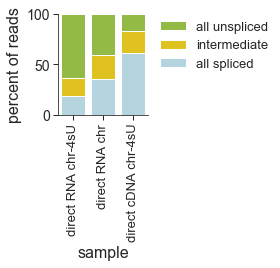

In [72]:
fig, ax = plt.subplots(figsize=(4,3.8))

# Plot the total reads
sns.barplot(x="sample", y="all_unspliced", data=all_splicing_percent_df,
            label="all unspliced", color="yellowgreen", order=['direct RNA chr-4sU', 'direct RNA chr','direct cDNA chr-4sU'])

# Plot the level of intermediate + unspliced reads
sns.barplot(x="sample", y="intermediate", data=all_splicing_percent_df,
            label="intermediate", color="gold", order=['direct RNA chr-4sU', 'direct RNA chr','direct cDNA chr-4sU'])

# Plot the level of spliced reads
sns.barplot(x="sample", y="all_spliced", data=all_splicing_percent_df,
            label="all spliced", color="lightblue", order=['direct RNA chr-4sU', 'direct RNA chr','direct cDNA chr-4sU'])


plt.xlabel("sample", fontsize=16)
plt.ylabel("percent of reads", fontsize=16)
plt.xticks(rotation=90, fontsize=13)

plt.ylim(0,100)

plt.tick_params(direction='out', length=5, width=1)

sns.despine(top=True, right=True)

plt.legend(bbox_to_anchor=(1.00, 1.05), fontsize=13, frameon=False)

plt.tight_layout()

plt.savefig('/path/to/Fig2A_proportion_spliced_direct-RNA_vs_cDNA_vs_chromatin_withReplicates.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


## Figure 2B

In [2]:
def get_discarded_features_wiRNAPET_wiNoPolyA_bedtool(annotation_df, polyA_window, ss_window_upstream, ss_window_downstream, RNAPET_df, RNAPET_window, nopolyA_bamFile):

    # make a set for all 3'SS coordinates
    features = []

    # loop through a file with intron coordinates
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        # check if feature is a gene and record region around polyA site
        if (feature == 'gene'):
            #chrom = 'chr'+str(annotation_df['chrom'].iloc[i])       # chromosome
            chrom = str(annotation_df['chrom'].iloc[i])
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            if (strand=='+'):
                polyA_start = end - polyA_window
                polyA_end = end + polyA_window
                
            if (strand=='-'):
                polyA_start = start - polyA_window
                polyA_end = start + polyA_window

            if (polyA_window > 0):
                features.append([chrom,polyA_start,polyA_end,gene,'polyA',strand])
            
        # check if feature is an intron and record region around 5'SS site   
        if (feature == 'intron'):
            #chrom = 'chr'+str(annotation_df['chrom'].iloc[i])       # chromosome
            chrom = str(annotation_df['chrom'].iloc[i])
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            # get 5' splice site positions for introns on each strand
            if (strand=='+'):
                ss5_start = int(start)-ss_window_upstream
                ss5_end = int(start)+ss_window_downstream
            if (strand=='-'):
                ss5_start = int(end)-ss_window_downstream
                ss5_end = int(end)+ss_window_upstream

            if (ss5_start > 0 and ss5_end > ss5_start):
                features.append([chrom,ss5_start,ss5_end,gene,name+"_SS",strand])

    # record regions around 3' end RNA-PET coordinates from ENCODE data
    for i in range(0,len(RNAPET_df)):

        # get features of line in RNA-PET bed file
        chrom = str(RNAPET_df.iloc[i]['chrom'])
        start = int(RNAPET_df.iloc[i]['start'])
        end = int(RNAPET_df.iloc[i]['end'])
        ID = RNAPET_df.iloc[i]['ID']
        score = RNAPET_df.iloc[i]['score'].astype(str)
        strand = RNAPET_df.iloc[i]['strand']
        size = RNAPET_df.iloc[i]['size'].split(',')
        loc = RNAPET_df.iloc[i]['loc'].split(',')

        # process file based on read strand
        # make a new bed file with only information about the polyA site

        if (strand == "+"):
            polyA_start = end - int(size[1]) + 1 - RNAPET_window
            polyA_end = end + RNAPET_window

        if (strand == "-"): 
            polyA_start = start + 1 - RNAPET_window
            polyA_end = start + int(size[0]) + RNAPET_window

        if (polyA_start > 0):
            features.append([chrom[3:],polyA_start,polyA_end,ID,'polyA',strand])
            
    nopolyA_df = nopolyA_bamFile.bam_to_bed().to_dataframe()
    for i in range(len(nopolyA_df)):

        chrom = str(nopolyA_df.iloc[i]['chrom'])
        read_start = nopolyA_df.iloc[i]['start']
        read_end = nopolyA_df.iloc[i]['end']
        read_name = nopolyA_df.iloc[i]['name']
        strand = nopolyA_df.iloc[i]['strand']
    
        if strand=="+":

            polyA_start = int(read_end)-50
            polyA_end = int(read_end)+50

        if strand=="-":

            polyA_start = int(read_start)-50
            polyA_end = int(read_start)+50

        if (polyA_start > 0):
            features.append([chrom,polyA_start,polyA_end,read_name,'polyA',strand]) 

    features_bedtool = BedTool(features)
    return features_bedtool


# make a bed tool with coordinates of read 3' ends
def get_read_end_bedtool(bamFile):

    bedFile = bamFile.bam_to_bed()
    bedFile_df = bedFile.to_dataframe(names=['chrom', 'start', 'end', 'name', 'score', 'strand'] , \
                               dtype={"chrom": str, "start": int, "end": int, "name": str, \
                                      "score": bytes, "strand": str}) # convert to a dataframe       
    
    read_end = []
        
    for i in range(0,len(bedFile_df)):
        chrom = str(bedFile_df['chrom'].iloc[i])
        start = int(bedFile_df['start'].iloc[i])
        end = int(bedFile_df['end'].iloc[i])
        read = bedFile_df['name'].iloc[i]
        score = bedFile_df['score'].iloc[i]
        strand = bedFile_df['strand'].iloc[i]

        if (strand == "-"):
            pos_1 = start
            pos_2 = start + 1

        if (strand == "+"):
            pos_1 = end - 1
            pos_2 = end

        read_end.append([chrom,pos_1,pos_2,read,score,strand])

    read_end_bedtool = BedTool(read_end)
    return read_end_bedtool


# intersect 3' ends with discarded features bed file 
# to get reads that will be removed from the analysis
def get_discarded_reads(bamFile, features):

    # get read ends and turn into a bedtool for intersecting 
    read_ends_bedtool = get_read_end_bedtool(bamFile)

    # intersect read ends with genome features
    intersect = read_ends_bedtool.intersect(features, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    intersect_df = intersect.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe

    unique_read_names = set(intersect_df['name_read'])

    return unique_read_names



# make a bed tool with intron coordinates
def get_introns_bedtool(annotation_df, window):

    # make a set for all 3'SS coordinates
    introns = []

    # loop through a file with intron coordinates
    # check if feature is an exon
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'intron'):
            chrom = annotation_df['chrom'].iloc[i]                  # chromosome
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            if (end-start > 2*window):
                start = start + window
                end = end - window 

            introns.append([chrom,start,end,gene,name,strand])
    
    introns_bedtool = BedTool(introns)
    return introns_bedtool


# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def human_spliceSites(intronFile):
    # make a set for all 3'SS coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = str(line.split('\t')[0])      # chromosome
        start = line.split('\t')[1]                 # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                   # end coordinate of intron (last base of intron)
        name = line.split('\t')[3]                  # gene name and polyA site for that gene (multiples are split with "_")
        strand = line.split('\t')[4][0]             # strand of gene with intron

        # get 3' SS positions for introns plus one base
        if strand=='+':
            pos1 = int(end)
            pos2 = int(end)+1
            pos5prime = int(start)+1
        if strand=='-':
            pos1 = int(start)
            pos2 = int(start)+1
            pos5prime = int(end)

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(pos1),str(pos2),str(name),str(pos5prime),str(strand)])

    spliceSites = BedTool(introns)
    intronFile.close()
    return spliceSites



# function to create a dataframe with reads that span 3'SS positions
def get_spliceSite_df(spliceSites, bamFile):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(spliceSites, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df = intersect.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    return df


def get_MinION_spliceCalls(df, min_overlap):
    
    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all reads that span splice sites
    for i in range(0,df.shape[0]):
        if df.strand_gene[i] == "-":
            align_3p_end = df.start_aln[i] # record 3' end of read for - strand genes
            align_5p_end = df.end_aln[i] # record 5' end of read for - strand genes
            pos_3SS = df.end_3SS[i] # record 3'SS position for - strand genes
            pos_5SS = df.pos_5SS[i] # record 5'SS position for - strand genes
            intron_start = pos_3SS # get position for the start of intron coordinate on negative strand
            intron_end = pos_5SS # get position for the end of intron coordinate on negative strand

        if df.strand_gene[i] == "+":
            align_3p_end = df.end_aln[i] # record 3' end of read for + strand genes
            align_5p_end = df.start_aln[i] # record 5' end of read for + strand genes
            pos_3SS = df.start_3SS[i] # record 3'SS position for + strand genes 
            pos_5SS = df.pos_5SS[i] # record 5'SS position for - strand genes 
            intron_start = pos_5SS # get position for the start of intron coordinate on positive strand
            intron_end = pos_3SS # get position for the end of intron coordinate on positive strand
            
        # calculate distance between 3'SS and 3'end of read 
        dist = abs(align_3p_end - pos_3SS) #*** double check this!!!

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df.cigar_aln[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # get the 3' softclip length
        if df.strand_aln[i]=="+":        
            last=len(CigarPairs)
            if(CigarPairs[last-1][1]=='S'):
                clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]=='H'):
                clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]!='S' or CigarPairs[last-1][1]!='H'):
                clip=0

        if df.strand_aln[i]=="-":
            if(CigarPairs[0][1]=='S'):
                clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]=='H'):
                clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]!='S' or CigarPairs[0][1]!='H'):
                clip=0

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df.start_aln[i]) 

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated 5' splice site
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated 3' splice site
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # assign strandedness to determine counts around 5'SS and 3'SS
        if(df.strand_gene[i]=='+'):
            around5SS_counts = start_counts
            around3SS_counts = end_counts

        elif(df.strand_gene[i]=="-"):
            around5SS_counts = end_counts
            around3SS_counts = start_counts

        # annotate splicing status based on CIGAR string information around splice sites
        if(around3SS_counts['N']==0 and around3SS_counts['M']>min_overlap/2):
            splice='NO'
        elif(around3SS_counts['N']>0 and around3SS_counts['N']<min_overlap*2):
            if(around5SS_counts['N']>0 and around5SS_counts['N']<min_overlap*2):
                splice='YES'
            else:
                splice='UNDETERMINED'
        else:
            splice='UNDETERMINED'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))
                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                intronLength = intron_end-intron_start
                difference = abs(intron_counts['M']+intron_counts['D']+intron_counts['S']-intronLength)
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)
                # if read is unspliced, at least 70% of the read has to match (CIGAR=M) the intron sequence
                # and at least 10 nucleotides must match (CIGAR=M) within the intron sequence
                if(intron_counts['M'] < 10 or ratio < 0.7):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'
        
        
        # get information on match percentage / error length 
        # this will be used as a quality control cutoff if necessary
        read_length = CigarOp_counts['M']+CigarOp_counts['I']
        error_rate = float(df.qual_aln[i])/float(read_length)

        spliceCalls.append([df.name_aln[i],df.chrom[i],str(intron_start),str(intron_end),str(align_5p_end),str(align_3p_end),str(read_length),df.strand_gene[i],str(error_rate),str(clip),str(dist),splice,df.name_gene_polyA[i]])
    
    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","read_start","read_end","read_length","strand","error_rate","end_clippling","dist_from_3SS","splice_status","gene_name_polyA"]
   
    return spliceCalls_df


def get_MinION_spliceCalls_noPolyA(gene_name_polyA, strand, read_end, polyA_dist):

    # delimeter to identify if read has a 3' end near a polyA site
    near_polyA = 'NO'

    # count the number of polyA sites associated with a gene
    polyA_count = int(len(gene_name_polyA.split('_'))/3)

    # loop through all polyA sites associated with the aligned gene
    for j in range(0,polyA_count):
        tag = gene_name_polyA.split('_')[j*3+0]
        gene = gene_name_polyA.split('_')[j*3+1]
        polyA = int(gene_name_polyA.split('_')[j*3+2])

        if (strand=='+' and int(read_end)>(polyA-polyA_dist)):
            near_polyA = 'YES'
        elif (strand=='-' and int(read_end)<(polyA+polyA_dist)):
            near_polyA = 'YES'   
    
    return near_polyA


def get_processed_splice_calls(df, read_overhang, max_softclip):
    
    df['near_polyA'] = df.apply(lambda row: get_MinION_spliceCalls_noPolyA(row.gene_name_polyA,row.strand,row.read_end,polyA_dist), axis=1)
    df_nopolyA = df[df['near_polyA']=='NO'].reset_index(drop=True)   
    df_capable = df_nopolyA[(df_nopolyA['read_length'].astype(int)-read_overhang)>df_nopolyA['dist_from_3SS'].astype(int)].reset_index(drop=True)
    df_softclip = df_capable[df_capable['end_clippling'].astype(int)<max_softclip].reset_index(drop=True)   
    
    return df_softclip


# function to create a dataframe with reads that span 3'SS positions
def get_spliceSite_df(spliceSites, bamFile):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(spliceSites, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df = intersect.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    return df


def get_discarded_splice_df(bamFile, discarded_reads, spliceSites, min_overlap, read_overhang, max_softclip):
    
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    filtered_reads_bedtool = bedFile.filter(lambda b: b.name not in discarded_reads)
    filtered_reads_bedtool = filtered_reads_bedtool.saveas()

    intersect = filtered_reads_bedtool.intersect(spliceSites, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    splicingReads = intersect.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    
    splicingCalls = get_MinION_spliceCalls(splicingReads, min_overlap) #determine splicing status and distance
    splice_df = get_processed_splice_calls(splicingCalls, read_overhang, max_softclip) #process files (e.g. not near polyA, splicing capable, and minimal softclip)

    return splice_df



def get_discarded_features_woPolyA_bedtool(annotation_df, ss_window_upstream, ss_window_downstream):

    # make a set for all 3'SS coordinates
    features = []

    # loop through a file with intron coordinates
    # check if feature is an exon
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        #if (feature == 'gene'):
        #    #chrom = 'chr'+str(annotation_df['chrom'].iloc[i])       # chromosome
        #    chrom = str(annotation_df['chrom'].iloc[i])
        #    start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
        #    end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
        #    gene = annotation_df['gene'].iloc[i]                    # gene name
        #    strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
        #    name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
         #   if (strand=='+'):
         #       polyA_start = end - polyA_window
         #       polyA_end = end + polyA_window
                
         #   if (strand=='-'):
         #       polyA_start = start - polyA_window
         #       polyA_end = start + polyA_window

         #   if (polyA_window >= 0):
         #       features.append([chrom,polyA_start,polyA_end,gene,'polyA',strand])
            
   
        if (feature == 'intron'):
            #chrom = 'chr'+str(annotation_df['chrom'].iloc[i])       # chromosome
            chrom = str(annotation_df['chrom'].iloc[i])
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            # get 5' splice site positions for introns on each strand
            if (strand=='+'):
                ss5_start = int(start)-ss_window_upstream
                ss5_end = int(start)+ss_window_downstream
            if (strand=='-'):
                ss5_start = int(end)-ss_window_downstream
                ss5_end = int(end)+ss_window_upstream

            if (ss5_start > 0 and ss5_end > ss5_start):
                features.append([chrom,ss5_start,ss5_end,gene,name+"_SS",strand])

    features_bedtool = BedTool(features)
    return features_bedtool


In [3]:
# set all variables for analysis
# set variables for analysis

# discarded reads
polyA_window = 50           # set window for polyA measurement from gtf file
ss_window_upstream = 50      # set window for splice sites measurement from gtf file (upstream of 5'SS)
ss_window_downstream = 10    # set window for splice sites measurement from gtf file (downstream of 5'SS)
RNAPET_window = 50          # set window for transcript ends from RNA-PET data

# splicing dataframe
min_overlap = 25    # overlap required to call splicing

# splicing dataframe
polyA_dist = 150    # distance from polyA site to designate 3' end within gene
read_overhang = 150    # distance that read has to overlap upstream of 3' SS
max_softclip = 150    # maximum softclipping allowed at the start of the read

In [5]:
# upload files for processing (K562 cells)

# upload hg38 annotation files for analysis
hg38_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_merge_parsed_sortByNameCoord.bed',header=None)
hg38_df.columns = ['chrom','start', 'end','gene','feature','strand']

# import RNAPET bed files with gene starts and ends
K562_RNAPET_cyt = pd.read_table('/path/to/annotation_files/K562_ENCODE_RNAPET_cytosol_hg38_CrossMap.bed',header=None)
K562_RNAPET_cyt.columns = ['chrom','start','end','ID','score','strand','start2','end2','zero','number','size','loc']
K562_RNAPET_chr = pd.read_table('/path/to/annotation_files/K562_ENCODE_RNAPET_chromatin_hg38_CrossMap.bed',header=None)
K562_RNAPET_chr.columns = ['chrom','start','end','ID','score','strand','start2','end2','zero','number','size','loc']

# merge cytoplasm and chromatin RNAPET bed files
K562_RNAPET_all = pd.concat([K562_RNAPET_cyt,K562_RNAPET_chr])

# install splice sites from K562 intron files
K562_medium_intronFile = open('/path/to/annotation_files/K562_intronCoords_mediumStringency.txt') # get intron coordinates
K562_medium_spliceSites = human_spliceSites(K562_medium_intronFile) # get splice sites

# K562 -polyA dataset for removing unannotated poly(A) sites (available from GEO accession number GSE123191)
K562_4sUchr_ONT_noA_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_noA_hg38_pass_minimap2_uniq_sort.bam')

# create a bed file with all regions that may not be representative of a transcription position
K562_discarded_features = get_discarded_features_wiRNAPET_wiNoPolyA_bedtool(hg38_df, polyA_window, ss_window_upstream, ss_window_downstream, K562_RNAPET_all, RNAPET_window, K562_4sUchr_ONT_noA_bamFile)


In [8]:
# Load files from nano-COP Mol Cell paper
# These files were produced using the script nanoCOP_splice_df_datasets.ipynb (https://github.com/churchmanlab/nano-COP/)
K562_4sUchr_ONT_1_splice_df = pd.read_table('/path/to/K562_4sUchr_ONT_1_hg38_medIntrons_discarded_splice_df.txt')
K562_4sUchr_ONT_2_splice_df = pd.read_table('/path/to/K562_4sUchr_ONT_2_hg38_medIntrons_discarded_splice_df.txt')
K562_4sUchr_ONT_3_splice_df = pd.read_table('/path/to/K562_4sUchr_ONT_3_hg38_medIntrons_discarded_splice_df.txt')

K562_4sUchr_ONT_4_splice_df = pd.read_table('/path/to/K562_4sUchr_ONT_4_hg38_medIntrons_discarded_splice_df.txt')
K562_4sUchr_ONT_5a_splice_df = pd.read_table('/path/to/K562_4sUchr_ONT_5a_hg38_medIntrons_discarded_splice_df.txt')
K562_4sUchr_ONT_5b_splice_df = pd.read_table('/path/to/K562_4sUchr_ONT_5b_hg38_medIntrons_discarded_splice_df.txt')
K562_4sUchr_ONT_5_splice_df = pd.concat([K562_4sUchr_ONT_5a_splice_df,K562_4sUchr_ONT_5b_splice_df]).reset_index(drop=True)

In [173]:
# Process chromatin RNA file - replicate 1 with poly(A) tailing

# upload alignment files for processing
K562_chr_RNA_1_bamFile = pybedtools.BedTool('/path/to/K562_chr_RNA_1_hg38_minimap2_uniq_sort.bam')

# remove reads that have 3' ends within the bed file for discarded regions
K562_chr_RNA_1_discarded_reads = get_discarded_reads(K562_chr_RNA_1_bamFile,K562_discarded_features)

# get splice dataframes for plotting (after discarding unwanted reads)
K562_chr_RNA_1_splice_df = get_discarded_splice_df(K562_chr_RNA_1_bamFile, K562_chr_RNA_1_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)

# save splice dataframes to file (to use again later for plotting)
K562_chr_RNA_1_splice_df.to_csv('/path/to/K562_chr_RNA_1_hg38_medIntrons_discarded_splice_df.txt', sep='\t', index=False, header=True)

In [ ]:
# Process chromatin RNA file - replicate 2 with poly(I) tailing

# upload alignment files for processing
K562_chr_RNA_2_bamFile = pybedtools.BedTool('/path/to/K562_chr_RNA_2_hg38_minimap2_uniq_sort.bam')

# remove reads that have 3' ends within the bed file for discarded regions
K562_chr_RNA_2_discarded_reads = get_discarded_reads(K562_chr_RNA_2_bamFile,K562_discarded_features)

# get splice dataframes for plotting (after discarding unwanted reads)
K562_chr_RNA_2_splice_df = get_discarded_splice_df(K562_chr_RNA_2_bamFile, K562_chr_RNA_2_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)

# save splice dataframes to file (to use again later for plotting)
K562_chr_RNA_2_splice_df.to_csv('/path/to/K562_chr_RNA_2_hg38_medIntrons_discarded_splice_df.txt', sep='\t', index=False, header=True)

In [175]:
# Add cDNA-specific functions

# make a bed tool with coordinates of read 3' ends
def get_read_start_bedtool(bamFile):

    bedFile = bamFile.bam_to_bed()
    bedFile_df = bedFile.to_dataframe(names=['chrom', 'start', 'end', 'name', 'score', 'strand'] , \
                               dtype={"chrom": str, "start": int, "end": int, "name": str, \
                                      "score": bytes, "strand": str}) # convert to a dataframe       
    
    read_start = []
        
    for i in range(0,len(bedFile_df)):
        chrom = str(bedFile_df['chrom'].iloc[i])
        start = int(bedFile_df['start'].iloc[i])
        end = int(bedFile_df['end'].iloc[i])
        read = bedFile_df['name'].iloc[i]
        score = bedFile_df['score'].iloc[i]
        strand = bedFile_df['strand'].iloc[i]

        if (strand == "+"):
            pos_1 = start
            pos_2 = start + 1

        if (strand == "-"):
            pos_1 = end - 1
            pos_2 = end

        read_start.append([chrom,pos_1,pos_2,read,score,strand])

    read_start_bedtool = BedTool(read_start)
    return read_start_bedtool

def get_discarded_reads_cDNA(bamFile, features):

    # get read ends and turn into a bedtool for intersecting 
    read_ends_bedtool = get_read_end_bedtool(bamFile)
    read_starts_bedtool = get_read_start_bedtool(bamFile)

    # intersect read ends with genome features
    intersect1 = read_ends_bedtool.intersect(features, wo=True, s=True) # for reads on same strand as feature, get read end
    intersect_df1 = intersect1.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe

    intersect2 = read_starts_bedtool.intersect(features, wo=True, S=True) # for reads on opposite strand of feature, get read start
    intersect_df2 = intersect2.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe
    
    intersect_df = pd.concat([intersect_df1,intersect_df2]).reset_index(drop=True)
    
    unique_read_names = set(intersect_df['name_read'])

    return unique_read_names

def get_MinION_spliceCalls_cDNA(df, min_overlap):
    
    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all reads that span splice sites
    for i in range(0,df.shape[0]):
        if (df.strand_gene[i] == "-") and (df.strand_aln[i] == '-'):
            align_3p_end = df.start_aln[i] # record 3' end of read for - strand genes
            align_5p_end = df.end_aln[i] # record 5' end of read for - strand genes
            pos_3SS = df.end_3SS[i] # record 3'SS position for - strand genes
            pos_5SS = df.pos_5SS[i] # record 5'SS position for - strand genes
            intron_start = pos_3SS # get position for the start of intron coordinate on negative strand
            intron_end = pos_5SS # get position for the end of intron coordinate on negative strand
            
        if (df.strand_gene[i] == "-") and (df.strand_aln[i] == '+'):
            align_3p_end = df.start_aln[i] # record 3' end of RNA - this is actually the read start
            align_5p_end = df.end_aln[i] # record 5' end of RNA - this is actually the read end
            pos_3SS = df.end_3SS[i] # record 3'SS position for + strand genes 
            pos_5SS = df.pos_5SS[i] # record 5'SS position for - strand genes 
            intron_start = pos_3SS # get position for the start of intron coordinate on positive strand
            intron_end = pos_5SS # get position for the end of intron coordinate on positive strand

        if (df.strand_gene[i] == "+") and (df.strand_aln[i] == '+'):
            align_3p_end = df.end_aln[i] # record 3' end of read for + strand genes
            align_5p_end = df.start_aln[i] # record 5' end of read for + strand genes
            pos_3SS = df.start_3SS[i] # record 3'SS position for + strand genes 
            pos_5SS = df.pos_5SS[i] # record 5'SS position for - strand genes 
            intron_start = pos_5SS # get position for the start of intron coordinate on positive strand
            intron_end = pos_3SS # get position for the end of intron coordinate on positive strand
            
        if (df.strand_gene[i] == "+") and (df.strand_aln[i] == '-'):
            align_3p_end = df.end_aln[i] # record 3' end of RNA - this is actually the read start
            align_5p_end = df.start_aln[i] # record 5' end of RNA - this is actually the read end
            pos_3SS = df.start_3SS[i] # record 3'SS position for + strand genes
            pos_5SS = df.pos_5SS[i] # record 5'SS position for + strand genes
            intron_start = pos_5SS # get position for the start of intron coordinate on positive strand
            intron_end = pos_3SS # get position for the end of intron coordinate on positive strand
            
            
        # calculate distance between 3'SS and 3'end of read 
        dist = abs(align_3p_end - pos_3SS) #*** double check this!!!

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df.cigar_aln[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # get the 3' softclip length
        if df.strand_aln[i]=="+":        
            last=len(CigarPairs)
            if(CigarPairs[last-1][1]=='S'):
                clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]=='H'):
                clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]!='S' or CigarPairs[last-1][1]!='H'):
                clip=0

        if df.strand_aln[i]=="-":
            if(CigarPairs[0][1]=='S'):
                clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]=='H'):
                clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]!='S' or CigarPairs[0][1]!='H'):
                clip=0

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df.start_aln[i]) 

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated 5' splice site
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated 3' splice site
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # assign strandedness to determine counts around 5'SS and 3'SS
        if(df.strand_gene[i]=='+'):
            around5SS_counts = start_counts
            around3SS_counts = end_counts

        elif(df.strand_gene[i]=="-"):
            around5SS_counts = end_counts
            around3SS_counts = start_counts

        # annotate splicing status based on CIGAR string information around splice sites
        if(around3SS_counts['N']==0 and around3SS_counts['M']>min_overlap/2):
            splice='NO'
        elif(around3SS_counts['N']>0 and around3SS_counts['N']<min_overlap*2):
            if(around5SS_counts['N']>0 and around5SS_counts['N']<min_overlap*2):
                splice='YES'
            else:
                splice='UNDETERMINED'
        else:
            splice='UNDETERMINED'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))
                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                intronLength = intron_end-intron_start
                difference = abs(intron_counts['M']+intron_counts['D']+intron_counts['S']-intronLength)
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)
                # if read is unspliced, at least 70% of the read has to match (CIGAR=M) the intron sequence
                # and at least 10 nucleotides must match (CIGAR=M) within the intron sequence
                if(intron_counts['M'] < 10 or ratio < 0.7):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'
        
        
        # get information on match percentage / error length 
        # this will be used as a quality control cutoff if necessary
        read_length = CigarOp_counts['M']+CigarOp_counts['I']
        error_rate = float(df.qual_aln[i])/float(read_length)

        spliceCalls.append([df.name_aln[i],df.chrom[i],str(intron_start),str(intron_end),str(align_5p_end),str(align_3p_end),str(read_length),df.strand_gene[i],df.strand_aln[i],str(error_rate),str(clip),str(dist),splice,df.name_gene_polyA[i]])
    
    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","read_start","read_end","read_length","strand","strand_aln","error_rate","end_clippling","dist_from_3SS","splice_status","gene_name_polyA"]
   
    return spliceCalls_df



def get_discarded_splice_df_cDNA(bamFile, discarded_reads, spliceSites, min_overlap, read_overhang, max_softclip):
    
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    filtered_reads_bedtool = bedFile.filter(lambda b: b.name not in discarded_reads)
    filtered_reads_bedtool = filtered_reads_bedtool.saveas()

    intersect1 = filtered_reads_bedtool.intersect(spliceSites, wo=True, s=True) # reads on same strand as feature
    splicingReads1 = intersect1.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    
    intersect2 = filtered_reads_bedtool.intersect(spliceSites, wo=True, S=True) # reads on opposite strand of feature
    splicingReads2 = intersect2.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    
    splicingReads = pd.concat([splicingReads1,splicingReads2]).reset_index(drop=True)
    
    # need to change the next functions so that they call the distance based on the strands of read and feature
    splicingCalls = get_MinION_spliceCalls_cDNA(splicingReads, min_overlap) #determine splicing status and distance
    splice_df = get_processed_splice_calls(splicingCalls, read_overhang, max_softclip) #process files (e.g. not near polyA, splicing capable, and minimal softclip)

    return splice_df

In [176]:
# Process cDNA-seq sample - replicate 1 with poly(A) tailing

K562_4sUchr_cDNA_1_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_cDNA_1_hg38_minimap2_uniq_sort.bam')

# remove reads that have 3' ends within the bed file for discarded regions
K562_4sUchr_cDNA_1_discarded_reads = get_discarded_reads_cDNA(K562_4sUchr_cDNA_1_bamFile,K562_discarded_features)

# get splice dataframes for plotting (after discarding unwanted reads)
K562_4sUchr_cDNA_1_splice_df = get_discarded_splice_df_cDNA(K562_4sUchr_cDNA_1_bamFile, K562_4sUchr_cDNA_1_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)

# save dataframe
K562_4sUchr_cDNA_1_splice_df.to_csv('/path/to/K562_4sUchr_cDNA_1_hg38_medIntrons_discarded_bothStrands_splice_df.txt', sep='\t', index=False)

In [177]:
# Process cDNA-seq sample - replicate 2 with poly(I) tailing

K562_4sUchr_cDNA_2_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_cDNA_2_hg38_minimap2_uniq_sort.bam')

# remove reads that have 3' ends within the bed file for discarded regions
K562_4sUchr_cDNA_2_discarded_reads = get_discarded_reads_cDNA(K562_4sUchr_cDNA_2_bamFile,K562_discarded_features)

# get splice dataframes for plotting (after discarding unwanted reads)
K562_4sUchr_cDNA_2_splice_df = get_discarded_splice_df_cDNA(K562_4sUchr_cDNA_2_bamFile, K562_4sUchr_cDNA_2_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)

# save dataframe
K562_4sUchr_cDNA_2_splice_df.to_csv('/path/to/K562_4sUchr_cDNA_2_hg38_medIntrons_discarded_bothStrands_splice_df.txt', sep='\t', index=False)

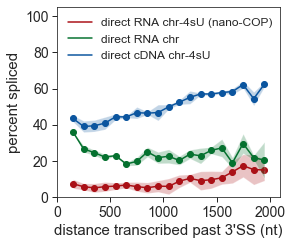

In [15]:
fig, ax = plt.subplots(figsize=(4,3.5))

######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      


######### get info for each sample - nano-COP #########
samples=['K562_4sUchr_ONT_1','K562_4sUchr_ONT_2','K562_4sUchr_ONT_3','K562_4sUchr_ONT_4','K562_4sUchr_ONT_5']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
plot_df_WT = plot_df.copy()
N_nanoCOP = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[5], label="direct RNA chr-4sU (nano-COP)")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[5], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[5])



######### get info for each sample - chromatin RNA only #########
samples=['K562_chr_RNA_1','K562_chr_RNA_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_chr = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Greens")[5], label="direct RNA chr")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greens")[5], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greens")[5])





######### get info for each sample - cDNA-seq #########
samples=['K562_4sUchr_cDNA_1','K562_4sUchr_cDNA_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_cDNA = np.sum(plot_df['count'])

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5], label="direct cDNA chr-4sU")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[5], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])


plt.ylabel("percent spliced", fontsize=15)
plt.xlabel("distance transcribed past 3'SS (nt)", fontsize=15)
#plt.text(100, 98, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction='out', length=5, width=1)

plt.xlim(0,2100)
plt.ylim(0,105)
plt.legend(loc=2, fontsize=12, frameon=False)

plt.savefig('/path/to/Fig2B_distance_transcribed_direct_RNA_vs_cDNA_vs_chromatin.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [11]:
N_nanoCOP

72937

In [12]:
N_chr

14227

In [13]:
N_cDNA

34463

## FIGURE 2C

In [38]:
# split splice dataframe files into different intron sizes
short_lim = 1000
long_lim = 10000

K562_4sUchr_ONT_1_short_splice_df = K562_4sUchr_ONT_1_splice_df[(K562_4sUchr_ONT_1_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_1_splice_df['intron_start'].astype(int)) <= short_lim]
K562_4sUchr_ONT_1_med_splice_df = K562_4sUchr_ONT_1_splice_df[((K562_4sUchr_ONT_1_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_1_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4sUchr_ONT_1_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_1_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_4sUchr_ONT_1_long_splice_df = K562_4sUchr_ONT_1_splice_df[(K562_4sUchr_ONT_1_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_1_splice_df['intron_start'].astype(int)) > long_lim]

K562_4sUchr_ONT_2_short_splice_df = K562_4sUchr_ONT_2_splice_df[(K562_4sUchr_ONT_2_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_2_splice_df['intron_start'].astype(int)) <= short_lim]
K562_4sUchr_ONT_2_med_splice_df = K562_4sUchr_ONT_2_splice_df[((K562_4sUchr_ONT_2_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_2_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4sUchr_ONT_2_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_2_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_4sUchr_ONT_2_long_splice_df = K562_4sUchr_ONT_2_splice_df[(K562_4sUchr_ONT_2_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_2_splice_df['intron_start'].astype(int)) > long_lim]

K562_4sUchr_ONT_3_short_splice_df = K562_4sUchr_ONT_3_splice_df[(K562_4sUchr_ONT_3_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_3_splice_df['intron_start'].astype(int)) <= short_lim]
K562_4sUchr_ONT_3_med_splice_df = K562_4sUchr_ONT_3_splice_df[((K562_4sUchr_ONT_3_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_3_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4sUchr_ONT_3_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_3_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_4sUchr_ONT_3_long_splice_df = K562_4sUchr_ONT_3_splice_df[(K562_4sUchr_ONT_3_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_3_splice_df['intron_start'].astype(int)) > long_lim]

K562_4sUchr_ONT_4_short_splice_df = K562_4sUchr_ONT_4_splice_df[(K562_4sUchr_ONT_4_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_4_splice_df['intron_start'].astype(int)) <= short_lim]
K562_4sUchr_ONT_4_med_splice_df = K562_4sUchr_ONT_4_splice_df[((K562_4sUchr_ONT_4_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_4_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4sUchr_ONT_4_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_4_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_4sUchr_ONT_4_long_splice_df = K562_4sUchr_ONT_4_splice_df[(K562_4sUchr_ONT_4_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_4_splice_df['intron_start'].astype(int)) > long_lim]

K562_4sUchr_ONT_5_short_splice_df = K562_4sUchr_ONT_5_splice_df[(K562_4sUchr_ONT_5_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_5_splice_df['intron_start'].astype(int)) <= short_lim]
K562_4sUchr_ONT_5_med_splice_df = K562_4sUchr_ONT_5_splice_df[((K562_4sUchr_ONT_5_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_5_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4sUchr_ONT_5_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_5_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_4sUchr_ONT_5_long_splice_df = K562_4sUchr_ONT_5_splice_df[(K562_4sUchr_ONT_5_splice_df['intron_end'].astype(int)-K562_4sUchr_ONT_5_splice_df['intron_start'].astype(int)) > long_lim]

K562_chr_RNA_1_short_splice_df = K562_chr_RNA_1_splice_df[(K562_chr_RNA_1_splice_df['intron_end'].astype(int)-K562_chr_RNA_1_splice_df['intron_start'].astype(int)) <= short_lim]
K562_chr_RNA_1_med_splice_df = K562_chr_RNA_1_splice_df[((K562_chr_RNA_1_splice_df['intron_end'].astype(int)-K562_chr_RNA_1_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_chr_RNA_1_splice_df['intron_end'].astype(int)-K562_chr_RNA_1_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_chr_RNA_1_long_splice_df = K562_chr_RNA_1_splice_df[(K562_chr_RNA_1_splice_df['intron_end'].astype(int)-K562_chr_RNA_1_splice_df['intron_start'].astype(int)) > long_lim]

K562_chr_RNA_2_short_splice_df = K562_chr_RNA_2_splice_df[(K562_chr_RNA_2_splice_df['intron_end'].astype(int)-K562_chr_RNA_2_splice_df['intron_start'].astype(int)) <= short_lim]
K562_chr_RNA_2_med_splice_df = K562_chr_RNA_2_splice_df[((K562_chr_RNA_2_splice_df['intron_end'].astype(int)-K562_chr_RNA_2_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_chr_RNA_2_splice_df['intron_end'].astype(int)-K562_chr_RNA_2_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_chr_RNA_2_long_splice_df = K562_chr_RNA_2_splice_df[(K562_chr_RNA_2_splice_df['intron_end'].astype(int)-K562_chr_RNA_2_splice_df['intron_start'].astype(int)) > long_lim]

K562_4sUchr_cDNA_1_short_splice_df = K562_4sUchr_cDNA_1_splice_df[(K562_4sUchr_cDNA_1_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_1_splice_df['intron_start'].astype(int)) <= short_lim]
K562_4sUchr_cDNA_1_med_splice_df = K562_4sUchr_cDNA_1_splice_df[((K562_4sUchr_cDNA_1_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_1_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4sUchr_cDNA_1_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_1_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_4sUchr_cDNA_1_long_splice_df = K562_4sUchr_cDNA_1_splice_df[(K562_4sUchr_cDNA_1_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_1_splice_df['intron_start'].astype(int)) > long_lim]

K562_4sUchr_cDNA_2_short_splice_df = K562_4sUchr_cDNA_2_splice_df[(K562_4sUchr_cDNA_2_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_2_splice_df['intron_start'].astype(int)) <= short_lim]
K562_4sUchr_cDNA_2_med_splice_df = K562_4sUchr_cDNA_2_splice_df[((K562_4sUchr_cDNA_2_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_2_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4sUchr_cDNA_2_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_2_splice_df['intron_start'].astype(int)) <= long_lim)]
K562_4sUchr_cDNA_2_long_splice_df = K562_4sUchr_cDNA_2_splice_df[(K562_4sUchr_cDNA_2_splice_df['intron_end'].astype(int)-K562_4sUchr_cDNA_2_splice_df['intron_start'].astype(int)) > long_lim]

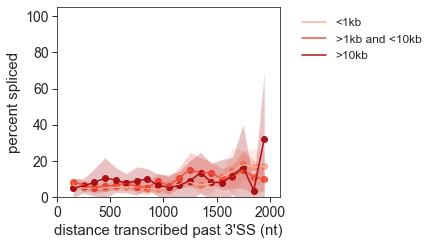

In [79]:
fig, ax = plt.subplots(figsize=(4,3.5))

######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      


######### get info for each sample - short introns #########
samples=['K562_4sUchr_ONT_1','K562_4sUchr_ONT_2','K562_4sUchr_ONT_3','K562_4sUchr_ONT_4','K562_4sUchr_ONT_5']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_short_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
plot_df_WT = plot_df.copy()
N_short = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[1], label="<1kb")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[1], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[1])



######### get info for each sample - short-medium introns #########

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_med_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_med = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[3], label=">1kb and <10kb")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[3])




######### get info for each sample - long introns #########

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_long_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_long= np.sum(plot_df['count'])

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[5], label=">10kb")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[5], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[5])



plt.ylabel("percent spliced", fontsize=15)
plt.xlabel("distance transcribed past 3'SS (nt)", fontsize=15)
#plt.text(100, 98, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction='out', length=5, width=1)

plt.xlim(0,2100)
plt.ylim(0,105)
plt.legend(loc=2, fontsize=12, frameon=False, bbox_to_anchor=(1.05, 1))

#plt.title("intron length - nano-COP", fontsize=18)

plt.savefig('/path/to/Fig2C_distance_transcribed_by_intron_length_nanoCOP.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [80]:
N_short

37489

In [81]:
N_med

32246

In [82]:
N_long

3202

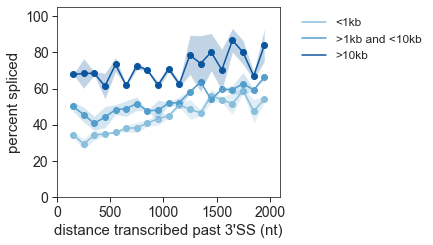

In [84]:
fig, ax = plt.subplots(figsize=(4,3.5))

######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      


######### get info for each sample - short introns #########
samples=['K562_4sUchr_cDNA_1','K562_4sUchr_cDNA_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_short_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
plot_df_WT = plot_df.copy()
N_short = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[2], label="<1kb")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[2], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[2])



######### get info for each sample - short-medium introns #########

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_med_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_med = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[3], label=">1kb and <10kb")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[3])




######### get info for each sample - long introns #########

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_long_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_long= np.sum(plot_df['count'])

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5], label=">10kb")
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[5], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])



plt.ylabel("percent spliced", fontsize=15)
plt.xlabel("distance transcribed past 3'SS (nt)", fontsize=15)
#plt.text(100, 98, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction='out', length=5, width=1)

plt.xlim(0,2100)
plt.ylim(0,105)
plt.legend(loc=2, fontsize=12, frameon=False, bbox_to_anchor=(1.05, 1))

#plt.title("intron length - cDNA", fontsize=18)

plt.savefig('/path/to/Fig2C_distance_transcribed_by_intron_length_cDNA-seq.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [85]:
N_short

15952

In [86]:
N_med

16149

In [87]:
N_long

2362

## FIGURE 2D

In [126]:
# Plot read length
# get read length from fastq file
def get_read_length_df(fastq):
    count=0
    readLength_list = []

    for line in fastq:

        count+=1

        if (count%4==1):
            name = line.split('@')[1].split(' ')[0]

        if (count%4==2):
            seq = line
            read_length = len(line)

        if (count%4==0):
            readLength_list.append([name, read_length])

    readLength_df = pd.DataFrame(readLength_list)
    readLength_df.columns = ['name','length']

    return readLength_df


In [127]:
# Upload fastq files for one representative sample per category
# Nano-COP (GEO accession number GSE123191)
K562_4sUchr_ONT_3_fastq = open('/path/to/K562_4sUchr_ONT_3_pass.fastq')
# Chromatin RNA replicate 1
K562_chr_RNA_1_fastq = open('/path/to/K562_chr_RNA_1_pass.fastq')
# cDNA-seq replicate 1
K562_4sUchr_cDNA_1_fastq = open('/path/to/K562_4sUchr_cDNA_1_pass.fastq')

K562_4sUchr_ONT_3_fastq_read_length_df = get_read_length_df(K562_4sUchr_ONT_3_fastq)
K562_chr_RNA_1_fastq_read_length_df = get_read_length_df(K562_chr_RNA_1_fastq)
K562_4sUchr_cDNA_1_fastq_read_length_df = get_read_length_df(K562_4sUchr_cDNA_1_fastq)


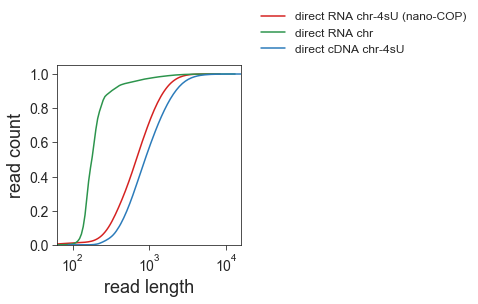

In [130]:
fig, ax = plt.subplots(figsize=(3.3,3.3))

K562_4sUchr_ONT_3_length = np.log10(K562_4sUchr_ONT_3_fastq_read_length_df['length'].values)
K562_chr_RNA_1_length = np.log10(K562_chr_RNA_1_fastq_read_length_df['length'].values)
K562_4sUchr_cDNA_1_length = np.log10(K562_4sUchr_cDNA_1_fastq_read_length_df['length'].values)

ax = sns.distplot(K562_4sUchr_ONT_3_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Reds")[4], bins=100, label='direct RNA chr-4sU (nano-COP)')
sns.distplot(K562_chr_RNA_1_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[4], bins=100, label='direct RNA chr')
sns.distplot(K562_4sUchr_cDNA_1_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[4], bins=100, label='direct cDNA chr-4sU')

x_labels = ["$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$"]
plt.xticks([2,3,4], x_labels, fontsize=16)
plt.yticks(fontsize=16)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("read count", fontsize=18)
ax.set_xlabel("read length", fontsize=18)
ax.legend(loc=0, fontsize=12, bbox_to_anchor=(1.05, 1), frameon=False)

plt.xlim(1.8,4.2)

plt.savefig('/path/to/Fig2D_sequenced_read_length_distribution_one_sample_each.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()